# Phase estimation Solution
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}\newcommand{\bra}[1]{\left\langle{#1}\right|}$

Let consider a matrix of the form 
$$\left[\begin{matrix}
1 & 0 \\
0 & a
\end{matrix}\right]$$
the eigenvalues and eigenvectors of this matrix are $v_1 = [1,0]^T$, $\lambda_1 = 1$ and $v_1 = [0,1]^T$, $\lambda_1 = a$.
 

The eigenvector corresponding to the eigenvalue $1$ is $\ket{0}$, and the eigenvector corresponding to the eigenvalue $a$ is $\ket{1}$.


If we take the phase gate:
$$\left[\begin{matrix}
1 & 0 \\
0 & e^{2 \pi i \varphi}
\end{matrix}\right]$$
the eigenvalue corresponding to the eigenvector $[0,1]^T$ is $e^{2 \pi i \varphi}$.


### Solution

Implement in Qiskit the phase estimation algorithm for the phase gate. 

First we define a fuction that creates the inverse QFT circuit.

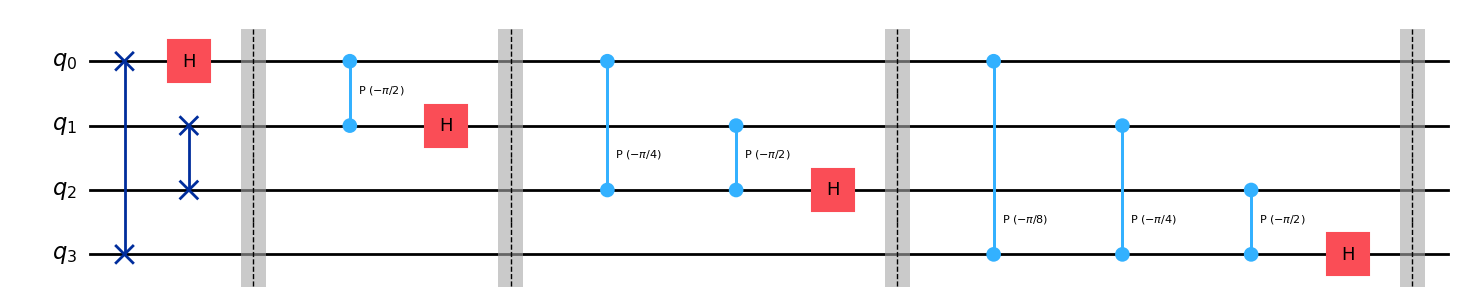

In [1]:
import math
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit


def qft_inverse(n):
    q = QuantumRegister(n, name='q')
    circ = QuantumCircuit(q, name="qft dag")
    """n-qubit QFT dagger on q in circ."""
    for qubit in range(n // 2):
        circ.swap(qubit, n - qubit - 1)
    
    for j in range(n):
        for k in range(j):
            circ.cp(-math.pi/float(2**(j-k)), q[k], q[j])
        circ.h(q[j])
        circ.barrier()
    
    return circ


qft_inverse(4).draw('mpl')

Now we define the exponential controlled phase gate.

In [2]:
def cu(phase, power):
    circ = QuantumCircuit(1, name=f"u^{str(power)}")
    for i in range(power):
        circ.p(phase, 0)
    
    return circ.to_gate().control(1)

Now, set up the QPE circuit.

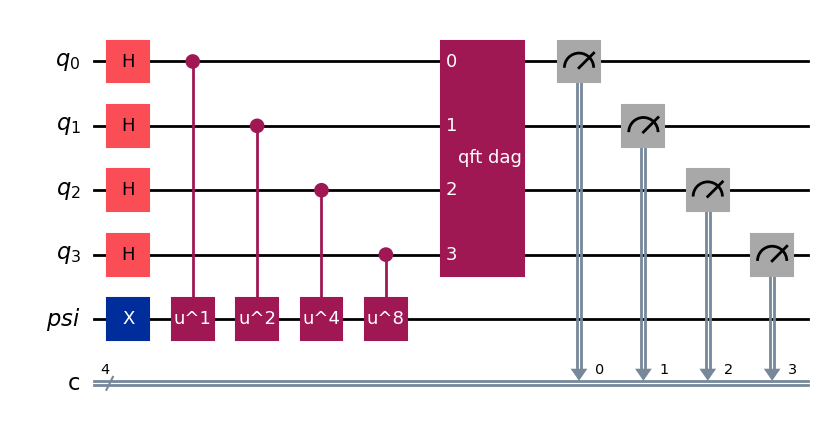

In [3]:


def qpe_circuit(precision, angle):
    q = QuantumRegister(precision, name='q')
    psi = QuantumRegister(1, name='psi')
    c = ClassicalRegister(precision, name='c')
    qpe = QuantumCircuit(q, psi, c)
    
    
    # Apply the Hadamard gates to the counting qubits
    for i in range(precision):
        qpe.h(q[i])
    
    # Prepare the eigenvector $\ket{1}$ in the last register
    qpe.x(psi)
    
    # Controlled unitary gates
    for i in range(precision):
        qpe.append(cu(2 * math.pi *angle, 2**(i)), [q[i], psi])
    
    # Apply the inverse QFT
    qpe.append(qft_inverse(precision), q[:])
    
    # Measure the counting qubits
    for i in range(precision):
        qpe.measure(q[i], c[i])
    
    return qpe

qpe_circuit(4, math.pi).draw('mpl') 

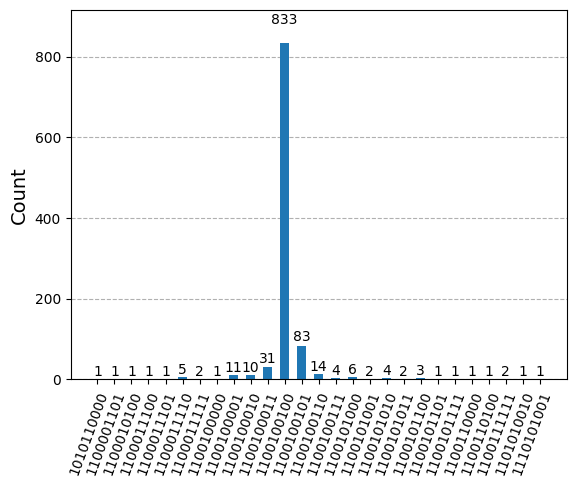

In [17]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

precision = 10

angle = math.pi/4

def run_circt(p, a):
    simulator = AerSimulator()
    
    qpe = qpe_circuit(p, a)
    circ = transpile(qpe, simulator)
    result = simulator.run(circ).result()
    counts = result.get_counts(circ)
    
    return counts

plot_histogram(run_circt(precision, angle))


In [21]:
precision = 5

angle = math.pi/4

counts = run_circt(precision, angle)
most_probable = int(max(counts, key=counts.get),2)

print(f"Counts: {counts}")
print(f"Most probable output in binary: {bin(most_probable)}")
print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**precision}")
print(f"Correct theta: {angle}")


Counts: {'11010': 32, '11001': 962, '10010': 1, '11011': 3, '01110': 2, '10111': 3, '11000': 10, '00100': 1, '10011': 1, '00001': 2, '01000': 1, '11100': 3, '10110': 2, '10101': 1}
Most probable output in binary: 0b11001
Most probable output: 25
Estimated theta: 0.78125
Correct theta: 0.7853981633974483
